In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, accuracy_score, confusion_matrix, 
                             classification_report, precision_recall_curve, auc)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Load the dataset
df_raw = pd.read_csv('../data/raw/data.csv')
df_raw.info()

/tmp/ipykernel_37584/2834592887.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('../data/raw/data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             195964 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392856 non-null  float64
 6   timeOnSite          196399 non-null  float64
 7   transactionRevenue  5277 non-null    float64
 8   transactions        5277 non-null    float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
dtypes: float64(5), int64(3), object(7)

In [4]:
for dtype in ['number', 'object']:
    display(df_raw.describe(include=dtype).T.style.set_caption(f"Resumen {dtype}"))

,count,mean,std,min,25%,50%,75%,max
visitNumber,392892.000000,2.361198,10.158865,1.000000,1.000000,1.000000,1.000000,389.000000
date,392892.000000,20170365.860542,169.257074,20170101.000000,20170216.000000,20170331.000000,20170516.000000,20170630.000000
bounces,195964.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hits,392892.000000,4.414065,8.555069,1.000000,1.000000,2.000000,4.000000,500.000000
pageviews,392856.000000,3.771015,6.414908,1.000000,1.000000,1.000000,4.000000,466.000000
timeOnSite,196399.000000,276.837127,485.765241,1.000000,33.000000,94.000000,287.000000,12136.000000
transactionRevenue,5277.000000,162.838217,898.877951,2.200000,29.180000,53.950000,114.530000,47082.060000
transactions,5277.000000,1.047754,0.571294,1.000000,1.000000,1.000000,1.000000,25.000000


,count,unique,top,freq
fullVisitorID,392892,324787,1957458976293878100,89
source,392892,210,(direct),167390
channelGrouping,392892,8,Organic Search,195434
browser,392892,39,Chrome,279456
deviceCategory,392892,3,desktop,267370
country,392892,213,United States,172224
city,392892,416,not available in demo dataset,228132


In [5]:
df_raw.sample(10, random_state=42)

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
371055,3139855877855255319,1,20170527,1.0,1,1.0,NaN,NaN,NaN,google,Organic Search,Opera Mini,mobile,Pakistan,not available in demo dataset
166384,5948316911528498625,12,20170108,1.0,1,1.0,NaN,NaN,NaN,(direct),Direct,Chrome,desktop,United States,Palo Alto
356358,9131153092635763429,1,20170324,NaN,2,2.0,NaN,NaN,NaN,(direct),Direct,UC Browser,mobile,Bangladesh,(not set)
238527,4091997502057423540,1,20170401,1.0,1,1.0,NaN,NaN,NaN,(direct),Direct,Chrome,desktop,United States,Laguna Beach
98816,9768299007846261384,1,20170125,NaN,2,2.0,7.0,NaN,NaN,(direct),Direct,Edge,desktop,United States,Seattle
328878,2180181348302784534,1,20170331,1.0,1,1.0,NaN,NaN,NaN,google,Organic Search,Safari,tablet,United States,not available in demo dataset
200489,4375955929952962215,1,20170525,1.0,1,1.0,NaN,NaN,NaN,google,Organic Search,Chrome,desktop,Ireland,Dublin
219726,0525144417932076270,1,20170408,1.0,1,1.0,NaN,NaN,NaN,google,Organic Search,Safari,desktop,Germany,Hamburg
191135,7492018795656453019,2,20170427,1.0,1,1.0,NaN,NaN,NaN,google,Organic Search,Chrome,mobile,United States,not available in demo dataset
143642,6198703767603809287,1,20170122,NaN,4,4.0,86.0,NaN,NaN,(direct),Referral,Chrome,desktop,United States,New York


| Variable             | Tipo      | Descripción                                                      | Comentario técnico / analítico                                                                                           |
| -------------------- | --------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| `fullVisitorId`      | `STRING`  | Identificador único de usuario                                   | Útil como clave para agrupación <br> No debe usarse como feature                                                     |
| `visitNumber`        | `INTEGER` | Número de sesión del usuario (1 = primera sesión)                | Puede ser una proxy de **engagement** o **madurez del usuario**                                                        |
| `date`               | `STRING`  | Fecha en formato `YYYYMMDD`                                      | Conviene convertir a `datetime` y extraer features como día, mes, semana                                               |
| `bounces`            | `INTEGER` | Valor 1 si el usuario abandonó sin interactuar; `null` si no     | Feature binaria que puede tener **alta correlación negativa con conversión**                                           |
| `hits`               | `INTEGER` | Número total de interacciones en la sesión                       | Proxy de **nivel de actividad/interés** en el sitio                                                                    |
| `pageviews`          | `INTEGER` | Páginas visitadas en la sesión                                   | Similar a `hits`, pero más enfocado en navegación                                                                      |
| `timeOnSite`         | `INTEGER` | Tiempo total de permanencia en la sesión (segundos)              | Muy informativo: más tiempo = mayor probabilidad de conversión                                                         |
| `transactionRevenue` | `INTEGER` | Ingresos por transacción (si la hubo)                            | No debe usarse directamente como feature si predices conversión <br> Útil para post-análisis o validación de revenue |
| `transactions`       | `INTEGER` | Número de transacciones en la sesión                             | Esta es tu **variable target binaria** (1 o más = convirtió)                                                          |
| `source`             | `STRING`  | Fuente de tráfico (ej. Google, Direct, etc.)                     | Potencialmente predictiva; requiere encoding                                                                           |
| `channelGrouping`    | `STRING`  | Agrupación de fuentes en canales (Organic, Paid, Referral, etc.) | Ya categorizada: **ideal para análisis de marketing**                                                                  |
| `browser`            | `STRING`  | Navegador utilizado (Chrome, Firefox, etc.)                      | Puede aportar para entender tipos de usuario, aunque el valor predictivo puede ser bajo                                |
| `deviceCategory`     | `STRING`  | Tipo de dispositivo (Mobile, Desktop, Tablet)                    | Alta importancia: los usuarios de desktop suelen convertir más                                                         |
| `country`            | `STRING`  | País de origen de la sesión                                      | Útil para segmentar usuarios o entender contextos geográficos                                                          |
| `city`               | `STRING`  | Ciudad de origen                                                 | Similar a `country`, aunque más granular; puede tener **mucha cardinalidad**                                           |


In [6]:
df_raw.columns.tolist()

['fullVisitorID',
 'visitNumber',
 'date',
 'bounces',
 'hits',
 'pageviews',
 'timeOnSite',
 'transactionRevenue',
 'transactions',
 'source',
 'channelGrouping',
 'browser',
 'deviceCategory',
 'country',
 'city']

In [7]:
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y%m%d')
df_raw['day'] = df_raw['date'].dt.day
df_raw['month'] = df_raw['date'].dt.month
df_raw['weekday'] = df_raw['date'].dt.dayofweek  # 0 = lunes, 6 = domingo
df_raw['converted'] = df_raw['transactions'].fillna(0).astype(int).apply(lambda x: 1 if x > 0 else 0)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fullVisitorID       392892 non-null  object        
 1   visitNumber         392892 non-null  int64         
 2   date                392892 non-null  datetime64[ns]
 3   bounces             195964 non-null  float64       
 4   hits                392892 non-null  int64         
 5   pageviews           392856 non-null  float64       
 6   timeOnSite          196399 non-null  float64       
 7   transactionRevenue  5277 non-null    float64       
 8   transactions        5277 non-null    float64       
 9   source              392892 non-null  object        
 10  channelGrouping     392892 non-null  object        
 11  browser             392892 non-null  object        
 12  deviceCategory      392892 non-null  object        
 13  country             392892 no

In [8]:
df = df_raw.copy()

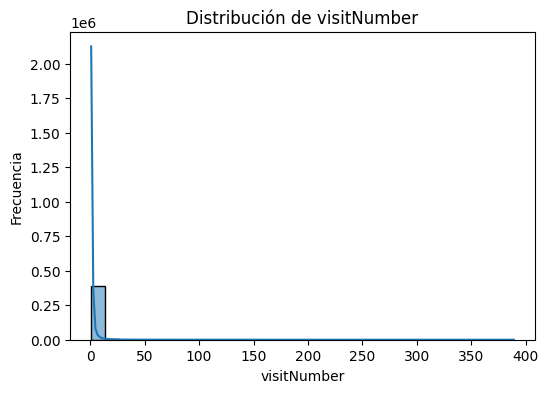

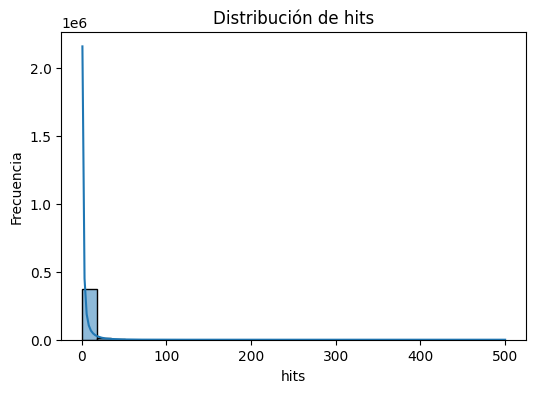

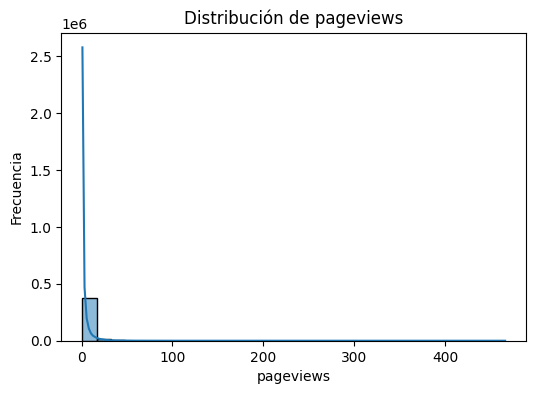

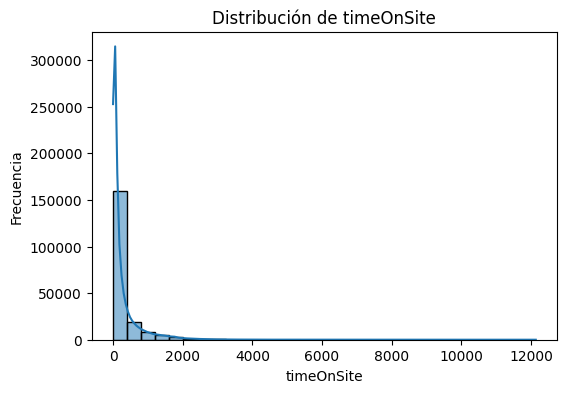

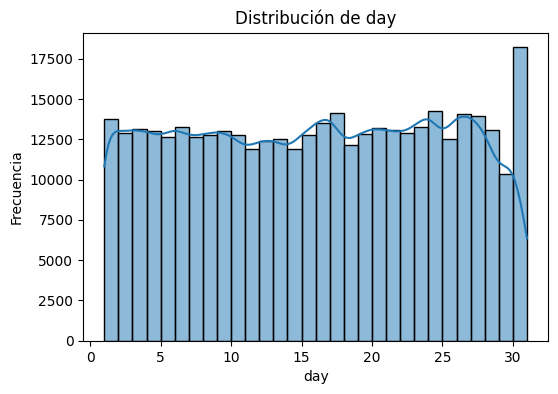

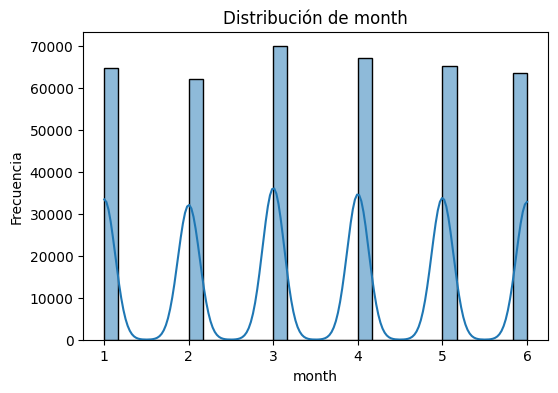

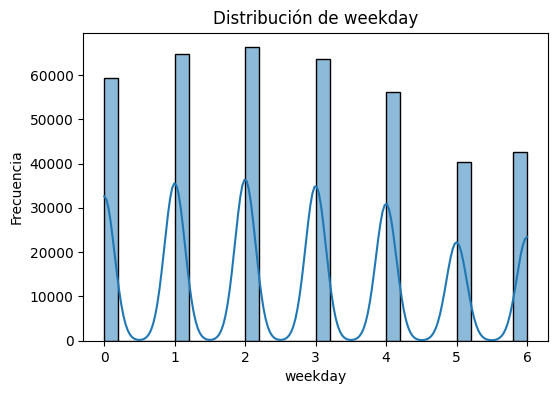

In [9]:
numerical_cols = ['visitNumber', 'hits', 'pageviews', 'timeOnSite', 'day', 'month', 'weekday']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

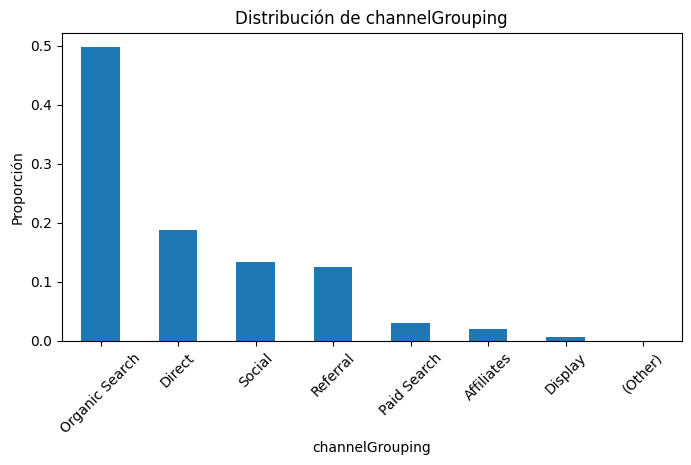

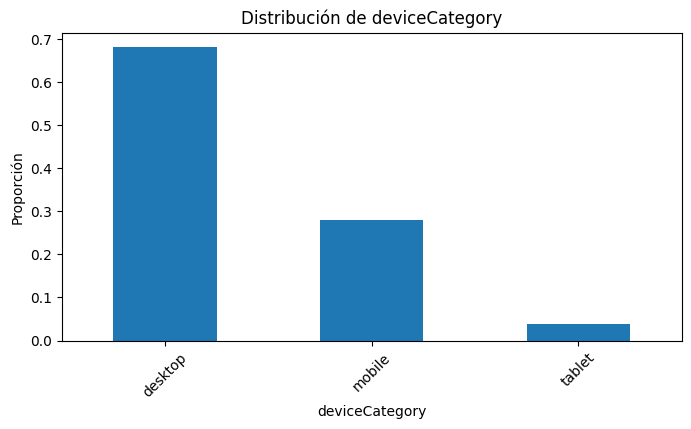

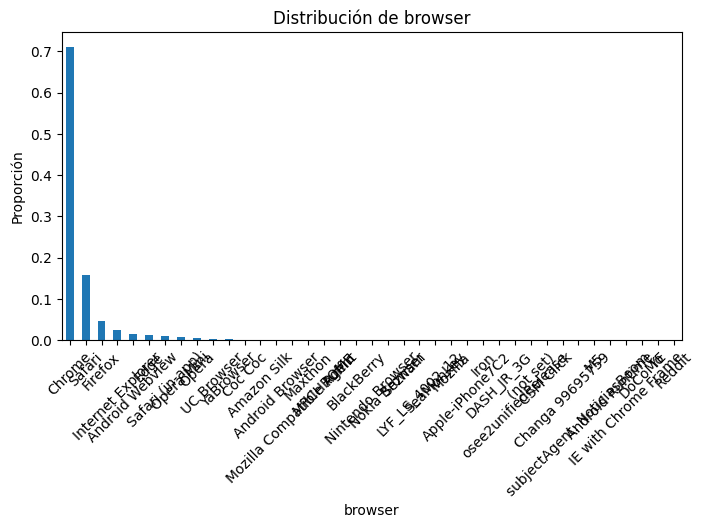

In [10]:
categorical_cols = ['channelGrouping', 'deviceCategory', 'browser']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.show()


## Conclusiones
- `visitNumber`, `hits`, `pageviews`, `timeOnSite`: long taial a la derecha, bajo engagement, pocos usuarios muy intensivos (outliers) => df['log_hits'] = np.log1p(df['hits'])
- `day`, `month`, `weekday`: conservar month y weekday
- `channelGrouping`: aplicar OneHotEncoding o LabelEncoding
- `deviceCategory`: destop 70%, analizar para el impacto en la conversión
- `browse`: Chrome 70%, agrupar rare categories en `others`.

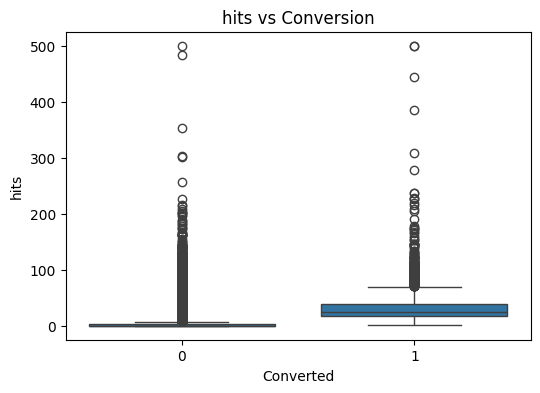

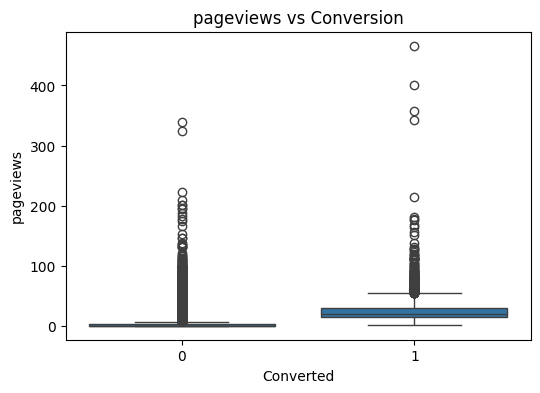

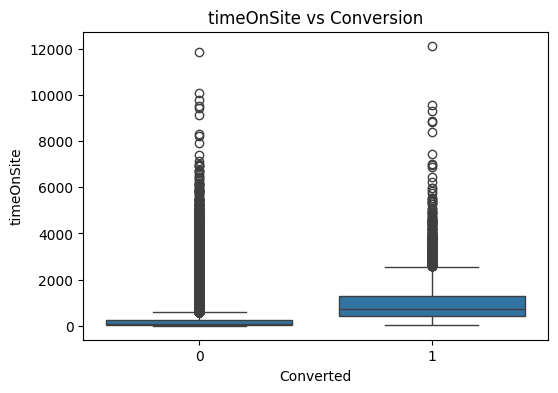

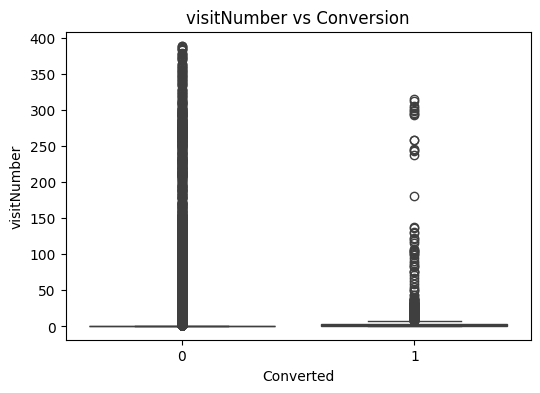

In [11]:
for col in ['hits', 'pageviews', 'timeOnSite', 'visitNumber']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='converted', y=col)
    plt.title(f'{col} vs Conversion')
    plt.xlabel('Converted')
    plt.ylabel(col)
    plt.show()


In [12]:
def plot_conversion_rate(df, col, top_n=None):
    # Agrupar y calcular tasa de conversión
    conv_rate = df.groupby(col)['converted'].mean().sort_values(ascending=False) * 100

    # Si hay muchas categorías, quedate con las top_n
    if top_n:
        conv_rate = conv_rate.head(top_n)

    # Graficar
    plt.figure(figsize=(8, 4))
    conv_rate.plot(kind='bar')
    plt.title(f'Tasa de conversión por {col}')
    plt.ylabel('Tasa de conversión')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


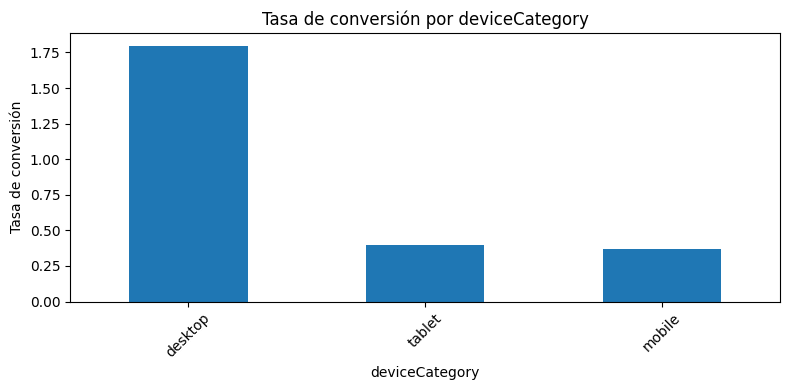

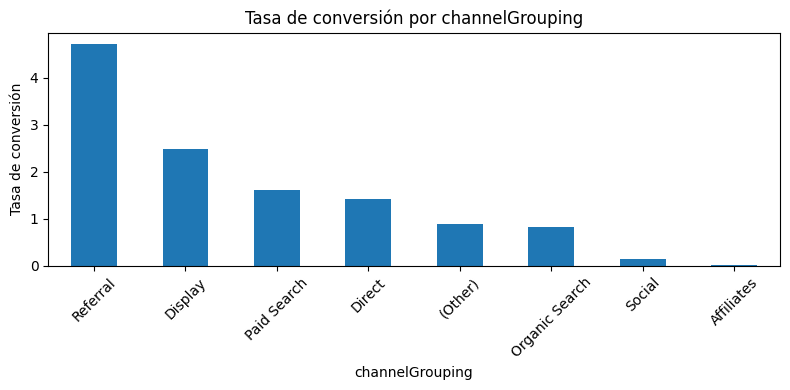

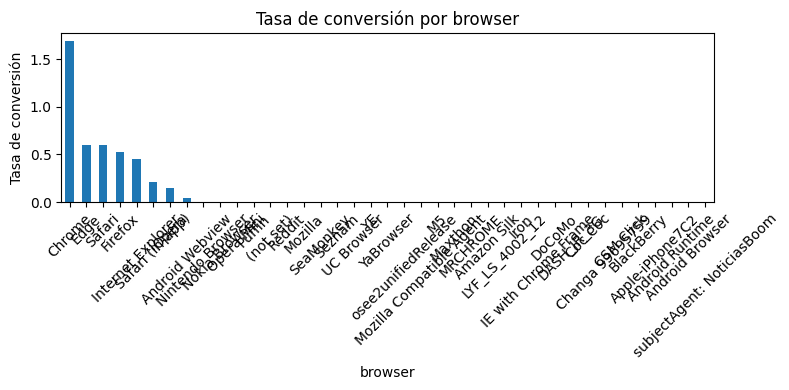

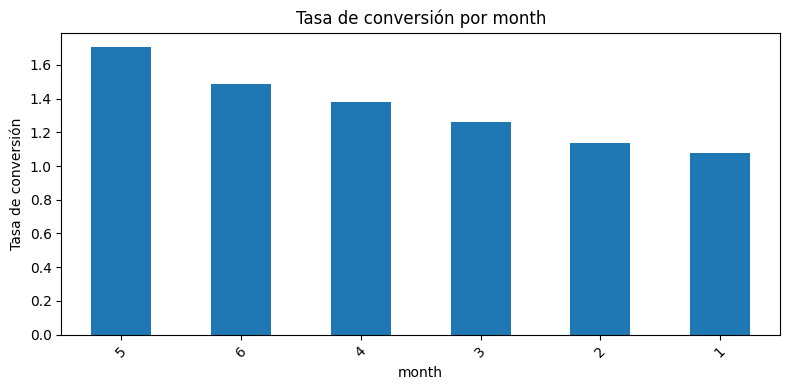

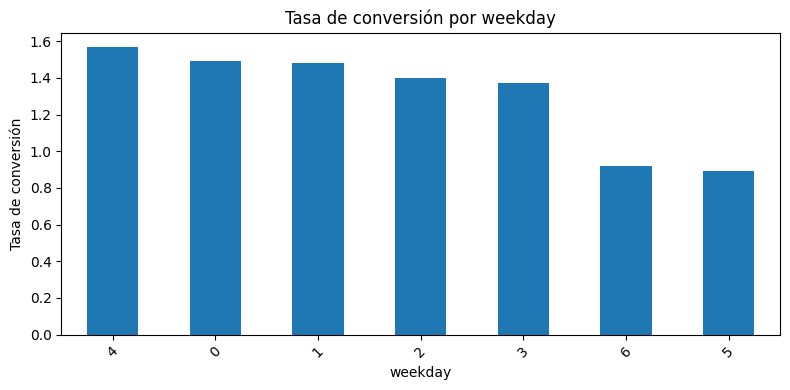

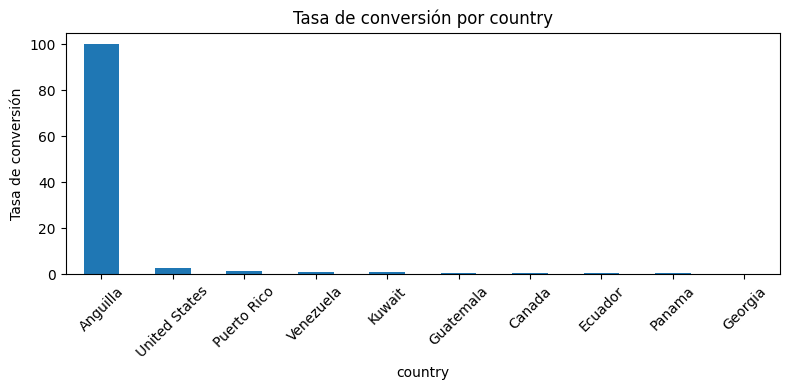

In [13]:
for col in ['deviceCategory', 'channelGrouping', 'browser', 'month', 'weekday']:
    plot_conversion_rate(df, col)

# Para country con top 10
plot_conversion_rate(df, 'country', top_n=10)


## Conclusiones:
- `hits`, `pageviews`, `timeOnSite`, `visitNumber`: actúan como un proxy
- `deviceCategory`, `channelGrouping`, `browse`: para análisis de explicación del perfil cliente
- `month`, `weekday`: días 4 y 0 son los días en los que más se convierte, mes a mes hay un aumento
- `country`: altamente sesgada, eliminar o agrupar en `other`

| Feature            | Incluir | Justificación                          |
| ------------------ | ------- | -------------------------------------- |
| `log_hits`         | ✅       | Predictiva, reduce skew                |
| `log_pageviews`    | ✅       | Similar                                |
| `log_timeOnSite`   | ✅       | Discriminante, mejor que original      |
| `log_visitNumber`  | ✅       | Muestra madurez del usuario            |
| `deviceCategory`   | ✅       | Dispositivo tiene alto impacto         |
| `channelGrouping`  | ✅       | Fuente de tráfico, muy informativa     |
| `browser_grouped`  | ✅       | Simplificada para reducir ruido        |
| `month`, `weekday` | ✅       | Patrones estacionales                  |
| `country`          | ❌       | Muy sesgada; solo incluir si se filtra |


In [14]:
df_interim = (
    df.copy()
    .assign(
        hits=lambda d: d['hits'].fillna(0),
        pageviews=lambda d: d['pageviews'].fillna(0),
        timeOnSite=lambda d: d['timeOnSite'].fillna(0),
        visitNumber=lambda d: d['visitNumber'].fillna(0),
        converted=lambda d: d['transactions'].fillna(0).astype(int).gt(0).astype(int),
        log_hits=lambda d: np.log1p(d['hits']),
        log_pageviews=lambda d: np.log1p(d['pageviews']),
        log_timeonsite=lambda d: np.log1p(d['timeOnSite']),
        log_visitnumber=lambda d: np.log1p(d['visitNumber']),
        browser_grouped=lambda d: d['browser'].where(d['browser'].isin(d['browser'].value_counts().index[:5]), 'Other')
    )
    .drop(columns=[
        'fullVisitorID', 'transactions', 'transactionRevenue',
        'hits', 'pageviews', 'timeOnSite', 'visitNumber', 'browser'
    ])
)

df_interim.to_csv('../data/interim/df_interim.csv', index=False)

In [23]:
df = pd.read_csv('../data/interim/df_interim.csv')

features = ['log_hits', 'log_pageviews', 'log_timeonsite', 'log_visitnumber',
            'deviceCategory', 'channelGrouping', 'browser_grouped', 'month', 'weekday']
target = 'converted'

X = df[features]
y = df[target]

cat_features = ['deviceCategory', 'channelGrouping', 'browser_grouped', 'month', 'weekday']
num_features = ['log_hits', 'log_pageviews', 'log_timeOnSite', 'log_visitNumber']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

smote = SMOTE(sampling_strategy=0.2, k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)


In [24]:
models = {
    'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:,1]

    results[name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }


/workspaces/SSR-DATA-SCIENTIST-TECHNICAL-CHALLENGE/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 62018, number of negative: 310091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7372
[LightGBM] [Info] Number of data points in the train set: 372109, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609441
[LightGBM] [Info] Start training from score -1.609441


In [25]:
print("K5")
pd.DataFrame(results).T.sort_values('F1', ascending=False)

K5


,Precision,Recall,F1,ROC AUC
LightGBM,0.413474,0.593365,0.487349,0.985501
XGBoost,0.406680,0.588626,0.481022,0.985136
RandomForest,0.395511,0.484360,0.435450,0.975663
LogReg,0.174581,0.968720,0.295846,0.982466


In [17]:
pd.DataFrame(results).T.sort_values('F1', ascending=False)

,Precision,Recall,F1,ROC AUC
LightGBM,0.378966,0.611374,0.467900,0.984792
XGBoost,0.384663,0.594313,0.467039,0.984687
RandomForest,0.406484,0.463507,0.433127,0.976704
LogReg,0.173132,0.968720,0.293763,0.982517


In [19]:
print("SMOTE 10%")
pd.DataFrame(results).T.sort_values('F1', ascending=False)

SMOTE 10%


,Precision,Recall,F1,ROC AUC
XGBoost,0.424073,0.574408,0.487923,0.985308
LightGBM,0.433071,0.469194,0.450409,0.984999
RandomForest,0.413666,0.424645,0.419083,0.976512
LogReg,0.173928,0.968720,0.294907,0.982495


In [22]:
print("SMOTE 15%")
pd.DataFrame(results).T.sort_values('F1', ascending=False)

SMOTE 15%


,Precision,Recall,F1,ROC AUC
LightGBM,0.427389,0.538389,0.476510,0.985387
XGBoost,0.399741,0.585782,0.475202,0.985034
RandomForest,0.405965,0.464455,0.433245,0.976805
LogReg,0.174106,0.968720,0.295162,0.982433


In [25]:
print("SMOTE 20%")
pd.DataFrame(results).T.sort_values('F1', ascending=False)

SMOTE 20%


,Precision,Recall,F1,ROC AUC
LightGBM,0.413474,0.593365,0.487349,0.985501
XGBoost,0.406680,0.588626,0.481022,0.985136
RandomForest,0.395511,0.484360,0.435450,0.975663
LogReg,0.174581,0.968720,0.295846,0.982466


In [ ]:
param_dist = {
    'num_leaves': [20, 31, 50, 70],
    'min_child_samples': [10, 20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 5, 10],
    'min_split_gain': [0.0, 0.1, 0.2],
    'max_depth': [4, 6, 8, -1]
}

lgbm = LGBMClassifier(random_state=42)

search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)

search.fit(X_train_resampled, y_train_resampled)
best_lgbm = search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7552
[LightGBM] [Info] Number of data points in the train set: 248072, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609448
[LightGBM] [Info] Start training from score -1.609448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7367
[LightGBM] [Info] Number of data points in the train set: 248073, number of used features: 34
[LightGBM] [In

In [ ]:
print(best_lgbm)

LGBMClassifier(max_depth=6, n_estimators=500, random_state=42, reg_alpha=0.1,
               reg_lambda=0, subsample=0.6)


In [ ]:
# K5
# Predicciones probabilísticas
y_proba = best_lgbm.predict_proba(X_test_transformed)[:, 1]

# Curva PR
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall (LightGBM tuned)")
plt.legend()
plt.grid()
plt.show()

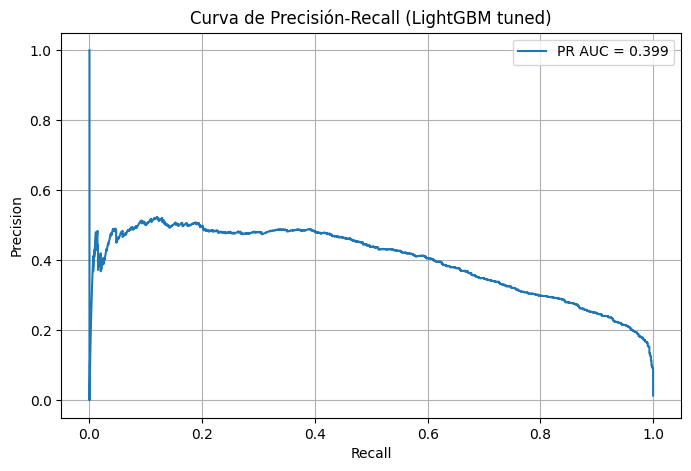

In [19]:
# Predicciones probabilísticas
y_proba = best_lgbm.predict_proba(X_test_transformed)[:, 1]

# Curva PR
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall (LightGBM tuned)")
plt.legend()
plt.grid()
plt.show()


In [20]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0

for t in np.arange(0.05, 0.6, 0.01):
    y_pred = (y_proba > t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Mejor threshold: {best_thresh}, F1: {best_f1}")

Mejor threshold: 0.36000000000000004, F1: 0.4864235841737781


In [ ]:
# K5
threshold = 0.36

y_pred_thresh = (y_proba > threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))

In [21]:
threshold = 0.36

y_pred_thresh = (y_proba > threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     77524
           1       0.41      0.59      0.49      1055

    accuracy                           0.98     78579
   macro avg       0.70      0.79      0.74     78579
weighted avg       0.99      0.98      0.98     78579

